## Цель на ноутбук
Необходимо отобрать те посты и комментарии, над которыми будем делать topic modeling и topic representation

### 1. Посты в каналах
Предлагается взять день начала конфликта - 24 февраля и последний полный день выборки. 

### 2. Комментарии к постам
Берем также 24 февраля и 7 марта, по следующим правилам чистим от ботов:
1. Комментарии, отправленные в течение очень короткого промежутка времени после публикации поста
2. Наличие ссылок в сообщении
3. Наличие номеров карт и телефонов
4. Медиа без текста

Эмбеддинги будем получать бертом, так что процессить текст не надо. 

In [1]:
import json
import re
from datetime import (
    datetime, timezone
)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 150)

# 1. Служебные функции

In [3]:
def is_comment_correct(comment: str) -> bool:
    pass

# 2. Константы

In [4]:
MESSAGES_PARQUET_FILE = "../data/processed/messages.parquet"
COMMENTS_PARQUET_FILE = "../data/processed/comments.parquet"

START_DATE_LEFT = datetime(
    2022, 2, 24, 0, 0, 0, 
    tzinfo=timezone.utc
)

START_DATE_RIGHT = datetime(
    2022, 2, 25, 0, 0, 0, 
    tzinfo=timezone.utc
)

END_DATE_LEFT = datetime(
    2022, 3, 7, 0, 0, 0, 
    tzinfo=timezone.utc
)

END_DATE_RIGHT = datetime(
    2022, 3, 8, 0, 0, 0, 
    tzinfo=timezone.utc
)

# 3. Выгружаем данные
Дополнително делаем `join_key`, так как у каждого канала своя нумерация постов и они могут дублироваться. 

In [5]:
messages = pd.read_parquet(
    MESSAGES_PARQUET_FILE
)

messages["join_key"] = messages.apply(
    lambda row: f"{row['channel_name']}_{row['id']}",
    axis=1
)

print(messages["join_key"].nunique())
print(messages.shape)
messages.head(5)

23043
(23043, 13)


,channel_name,channel_orientation,comments_unavailable,id,date,edit_date,message,views,forwards,media,legacy,comments_count,join_key
0,readovkanews,rus,False,27683,2022-03-08 11:07:02+00:00,2022-03-08 11:07:13+00:00,"❗️В МЧС РФ заявили, что Россия доставила на Ук...",102751.0,2.0,False,True,106,readovkanews_27683
1,readovkanews,rus,False,27685,2022-03-08 11:39:16+00:00,2022-03-08 11:39:37+00:00,❗️Британская нефтегазовая компания British Pet...,88669.0,106.0,False,True,155,readovkanews_27685
2,readovkanews,rus,False,27682,2022-03-08 10:49:32+00:00,2022-03-08 10:49:44+00:00,"СК РФ установит украинских должностных лиц, пр...",108785.0,69.0,False,True,124,readovkanews_27682
3,readovkanews,rus,False,27688,2022-03-08 12:08:45+00:00,2022-03-08 12:08:57+00:00,В Белграде выразили поддержку России — фанаты ...,71555.0,343.0,True,True,185,readovkanews_27688
4,readovkanews,rus,False,27690,2022-03-08 12:19:26+00:00,2022-03-08 12:31:35+00:00,❗️Крупнейшая в мире криптобиржа Binance с 9 ма...,69515.0,820.0,False,True,238,readovkanews_27690


In [6]:
comments = pd.read_parquet(
    COMMENTS_PARQUET_FILE
)

comments = comments[
    (
        (
            (comments["comment_date"] >= START_DATE_LEFT)
            & (comments["comment_date"] < START_DATE_RIGHT)
        )
        | (
            (comments["comment_date"] >= END_DATE_LEFT)
            & (comments["comment_date"] < END_DATE_RIGHT)
        )
    )
]

comments["join_key"] = comments.apply(
    lambda row: f"{row['channel_name']}_{row['message_id']}",
    axis=1
)

comments["comment_date_truncated"] = comments["comment_date"].apply(
    lambda value: f"{value.year}-{value.month}-{value.day}, {value.hour}:00 - {value.hour}:59"
)

print(comments["join_key"].nunique())
print(comments.shape)
comments.head(5)

967
(104536, 10)


,channel_name,channel_orientation,message_id,comment_id,comment_date,comment_edit_date,comment_message,comment_media,join_key,comment_date_truncated
10228,readovkanews,rus,27640,1671477,2022-03-07 22:34:41+00:00,NaT,"Может многие и не хотят, но это не значит, что...",False,readovkanews_27640,"2022-3-7, 22:00 - 22:59"
10229,readovkanews,rus,27640,1671462,2022-03-07 22:32:25+00:00,NaT,"Он окруженный стоит, еще в городе не заходили....",False,readovkanews_27640,"2022-3-7, 22:00 - 22:59"
10230,readovkanews,rus,27640,1671433,2022-03-07 22:26:33+00:00,NaT,Неважно куда сейчас . Речь о спасении жизни.,False,readovkanews_27640,"2022-3-7, 22:00 - 22:59"
10231,readovkanews,rus,27640,1671424,2022-03-07 22:25:41+00:00,NaT,"Из Харькова многие не хотят выходить, просто н...",False,readovkanews_27640,"2022-3-7, 22:00 - 22:59"
10232,readovkanews,rus,27640,1671410,2022-03-07 22:24:29+00:00,NaT,Такие вопросы должны решать военные обеих стор...,False,readovkanews_27640,"2022-3-7, 22:00 - 22:59"


# 4. Смотрим у каких каналов есть комментарии
Комментарии есть только у двух каналов - NEXTA и Readovka, при этом 24 не все посты в NEXTA были открыты для комментирования. 

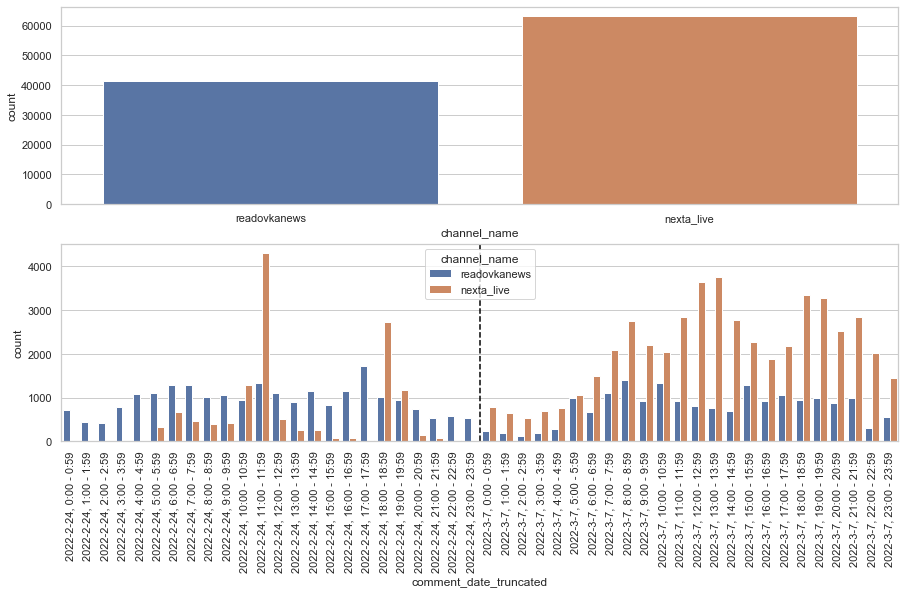

In [7]:
date_plot_order = pd.unique(
    comments.sort_values("comment_date")["comment_date_truncated"]
)


figure = plt.figure(figsize=(15, 8))
grid = figure.add_gridspec(2, 1)

ax_channel = figure.add_subplot(grid[0, 0])
sns.countplot(x="channel_name", data=comments, ax=ax_channel)

ax_date = figure.add_subplot(grid[1, 0])
sns.countplot(
    x="comment_date_truncated", data=comments, 
    ax=ax_date, order=date_plot_order,
    hue="channel_name"
)

plt.xticks(rotation=90)
plt.axvline(
    x=23.5, color="black", linestyle="--"
)

# 5. Чистим комментарии

In [8]:
comments_enriched = pd.merge(
    comments, messages, 
    on="join_key",
    how="inner"
)

print(comments_enriched.shape)
assert comments_enriched.shape[0] == comments.shape[0]

comments_enriched.head(5)

(104536, 22)


,channel_name_x,channel_orientation_x,message_id,comment_id,comment_date,comment_edit_date,comment_message,comment_media,join_key,comment_date_truncated,channel_name_y,channel_orientation_y,comments_unavailable,id,date,edit_date,message,views,forwards,media,legacy,comments_count
0,readovkanews,rus,27640,1671477,2022-03-07 22:34:41+00:00,NaT,"Может многие и не хотят, но это не значит, что...",False,readovkanews_27640,"2022-3-7, 22:00 - 22:59",readovkanews,rus,False,27640,2022-03-07 21:11:57+00:00,2022-03-07 21:12:03+00:00,Россия объявляет «режим тишины» с 10:00 8 март...,190786.0,128.0,False,True,93
1,readovkanews,rus,27640,1671462,2022-03-07 22:32:25+00:00,NaT,"Он окруженный стоит, еще в городе не заходили....",False,readovkanews_27640,"2022-3-7, 22:00 - 22:59",readovkanews,rus,False,27640,2022-03-07 21:11:57+00:00,2022-03-07 21:12:03+00:00,Россия объявляет «режим тишины» с 10:00 8 март...,190786.0,128.0,False,True,93
2,readovkanews,rus,27640,1671433,2022-03-07 22:26:33+00:00,NaT,Неважно куда сейчас . Речь о спасении жизни.,False,readovkanews_27640,"2022-3-7, 22:00 - 22:59",readovkanews,rus,False,27640,2022-03-07 21:11:57+00:00,2022-03-07 21:12:03+00:00,Россия объявляет «режим тишины» с 10:00 8 март...,190786.0,128.0,False,True,93
3,readovkanews,rus,27640,1671424,2022-03-07 22:25:41+00:00,NaT,"Из Харькова многие не хотят выходить, просто н...",False,readovkanews_27640,"2022-3-7, 22:00 - 22:59",readovkanews,rus,False,27640,2022-03-07 21:11:57+00:00,2022-03-07 21:12:03+00:00,Россия объявляет «режим тишины» с 10:00 8 март...,190786.0,128.0,False,True,93
4,readovkanews,rus,27640,1671410,2022-03-07 22:24:29+00:00,NaT,Такие вопросы должны решать военные обеих стор...,False,readovkanews_27640,"2022-3-7, 22:00 - 22:59",readovkanews,rus,False,27640,2022-03-07 21:11:57+00:00,2022-03-07 21:12:03+00:00,Россия объявляет «режим тишины» с 10:00 8 март...,190786.0,128.0,False,True,93


In [9]:
comments_enriched["comment_message"] = comments_enriched["comment_message"].str.replace(
    "\xa0", " ", regex=False
).str.replace(
    "\n", " ", regex=False
).str.replace(
    # emoji
    "\s+", 
    " ", regex=True
).str.strip()

## 5.1. Выкидываем выбросы по времени

In [10]:
comments_enriched["comment_delta"] = (
    comments_enriched["comment_date"] - comments_enriched["date"]
).dt.total_seconds()

(
    comments_enriched["comment_delta"].quantile(0.05), 
    comments_enriched["comment_delta"].quantile(0.95)
)

(50.0, 21971.0)

In [11]:
comments_enriched = comments_enriched[
    (
        (comments_enriched["comment_delta"] > comments_enriched["comment_delta"].quantile(0.05))
        & (comments_enriched["comment_delta"] < comments_enriched["comment_delta"].quantile(0.95))
    )
]

comments_enriched.shape

(94059, 23)

## 5.2. Выкидываем медиа без текста

In [12]:
comments_enriched = comments_enriched[
    ~(
        comments_enriched["comment_message"] == ""
    )
]

comments_enriched.shape

(89355, 23)

## 5.3. Выкидываем ссылки

In [13]:
comments_enriched = comments_enriched[
    ~comments_enriched["comment_message"].str.contains("https?", regex=True, flags=re.IGNORECASE)
]

comments_enriched.shape

(88574, 23)

## 5.4. Выкидываем номера телефонов и карт

In [14]:
comments_enriched = comments_enriched[
    ~comments_enriched["comment_message"].str.contains("(?:\d\s*){8,}", regex=True, flags=re.IGNORECASE)
]

comments_enriched.shape

(88544, 23)

## 5.5. Спам и реклама

In [15]:
comment_messages_vc = comments_enriched["comment_message"].value_counts()
comment_messages_vc = comment_messages_vc[comment_messages_vc > 2].reset_index(drop=False)

comment_messages_vc["len"] = comment_messages_vc["index"].apply(len)

comment_messages_vc = comment_messages_vc[
    comment_messages_vc["len"] > comment_messages_vc["len"].quantile(0.85)
]

print(
    comment_messages_vc.shape, 
    comment_messages_vc["comment_message"].sum()
)

comment_messages_vc.head(5)

(88, 3) 545


,index,comment_message,len
4,"Для кого Украина не враг, завтра в 12:00 - Рид...",74,59
13,"Для кого Украина не враг, завтра в 12:00 - Рид...",30,88
31,Да....😕😕ТАК РУСИШШВАЙНОВ НЕ ОПУСКАЛИ ДАЖЕ В АФ...,17,135
33,Ебем хохлов братья вперёд за славян!!!,16,38
39,Мы один народ братья по крови давайте закончим...,16,97


In [16]:
comments_enriched = comments_enriched[
    ~comments_enriched["comment_message"].isin(
        comment_messages_vc["index"].values
    )
]

comments_enriched.shape

(87999, 23)

In [17]:
comments_enriched = comments_enriched[
    ~comments_enriched["comment_message"].str.contains("@[a-z0-9]", regex=True, flags=re.IGNORECASE)
]

comments_enriched.shape

(87947, 23)

## 5.6. Выборка для topic modeling

In [43]:
comments_to_modeling = comments_enriched[
    [
        "channel_name_x", "channel_orientation_x", 
        "comment_date", "comment_message", "id"
    ]
]

print(comments_to_modeling.shape)
comments_to_modeling.sample(5)

(87947, 5)


,channel_name_x,channel_orientation_x,comment_date,comment_message,id
55079,nexta_live,ukr,2022-03-07 17:45:07+00:00,"Лидия, я думаю Вам нужно нагого раскрыть глаза...",20362
45914,nexta_live,ukr,2022-03-07 20:35:38+00:00,"А зачем мне мир , где нет России?",20405
3524,readovkanews,rus,2022-03-07 20:34:18+00:00,"""Есть место им в полях России Среди нечуждых и...",27634
21930,readovkanews,rus,2022-02-24 18:54:24+00:00,Бизнес — есть бизнес 💁‍♂,26522
47852,nexta_live,ukr,2022-03-07 19:54:35+00:00,Велкам в Тетрис и Змейку на 3310.)),20393


# 6. Чистим посты

In [18]:
messages = messages[
    (
        (
            (messages["date"] >= START_DATE_LEFT)
            & (messages["date"] < START_DATE_RIGHT)
        )
        | (
            (messages["date"] >= END_DATE_LEFT)
            & (messages["date"] < END_DATE_RIGHT)
        )
    )
]

messages["date_truncated"] = messages["date"].apply(
    lambda value: f"{value.year}-{value.month}-{value.day}, {value.hour}:00 - {value.hour}:59"
)

messages.shape

(3824, 14)

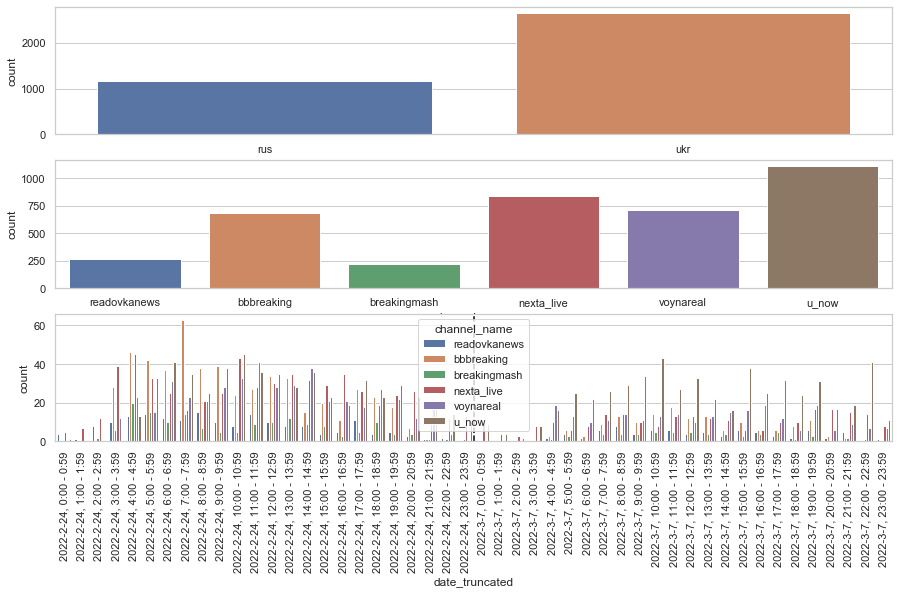

In [19]:
date_plot_order = pd.unique(
    messages.sort_values("date")["date_truncated"]
)


figure = plt.figure(figsize=(15, 8))
grid = figure.add_gridspec(3, 1)

ax_orient = figure.add_subplot(grid[0, 0])
sns.countplot(x="channel_orientation", data=messages, ax=ax_orient)

ax_channel = figure.add_subplot(grid[1, 0])
sns.countplot(x="channel_name", data=messages, ax=ax_channel)

ax_date = figure.add_subplot(grid[2, 0])
sns.countplot(
    x="date_truncated", data=messages, 
    ax=ax_date, order=date_plot_order,
    hue="channel_name"
)

plt.xticks(rotation=90)
plt.axvline(
    x=23.5, color="black", linestyle="--"
)

## 6.1. Убираем из постов отличительные черты каналов (названия, приписки, emoji и т.п)

In [20]:
with open("../data/raw/codes.json", "r") as codes_file:
    emoji_codes = json.load(codes_file)
    
regex_emoji_pattern = r"|".join(
    re.escape(code) for code in emoji_codes.keys()
)

In [21]:
messages["message"] = messages["message"].str.replace(
    "УС > Подписаться", " ", regex=False
).str.replace(
    "Реальная Война", " ", regex=False
).str.replace(
    "Readovka", " ", regex=False
).str.replace(
    "\xa0", " ", regex=False
).str.replace(
    "\n", " ", regex=False
).str.replace(
    "!!", " ", regex=False
).str.replace(
    "‼", " ", regex=False
).str.replace(
    # emoji
    regex_emoji_pattern, 
    " ", regex=True
).str.replace(
    # emoji
    "\s+", 
    " ", regex=True
).str.strip()

## 6.2. Сносим пустые посты (медиа)

In [29]:
messages = messages[
    messages["message"] != ""
]

messages.shape

(3473, 14)

## 6.3. Выборка для topic modeling

In [34]:
messages_to_modeling = messages[
    [
        "channel_name", "channel_orientation",
        "date", "message"
    ]
]

print(messages_to_modeling.shape)
messages_to_modeling.sample(5)

(3473, 4)


,channel_name,channel_orientation,date,message
9987,voynareal,ukr,2022-03-07 17:08:30+00:00,"Нардеп ОПЗЖ Юрій Бойко відмовився говорити ""Пу..."
1635,bbbreaking,rus,2022-03-07 04:40:07+00:00,️Netflix приостанавливает работу в России Ране...
14539,voynareal,ukr,2022-02-24 08:29:57+00:00,"«Нас поебашило из ГРАДа. Хорошо, что все живы ..."
3981,bbbreaking,rus,2022-02-24 07:00:24+00:00,Зеленский призвал украинцев не поддаваться панике
22727,u_now,ukr,2022-02-24 08:06:52+00:00,Администрация Эрдогана рассматривает специальн...


# 7. Выгружаем

In [46]:
comments_to_modeling.to_parquet(
    "../data/processed/comments_to_modeling.parquet"
)

messages_to_modeling.to_parquet(
    "../data/processed/messages_to_modeling.parquet"
)